# Atlas with Histogram

In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
#from scipy.spatial.distance import dice

In [2]:
use_atlas = 'mni'
max_intens = 999

# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2

In [3]:
# Normalize array from 0 to max_intens
def normalize(target_array, max_intens=255):
    target_array -= target_array.min()
    normalized_array = max_intens * np.divide(target_array, target_array.max())
    return normalized_array.astype(int)

def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()
    
def show_slice_data(data, slice_no):
    plt.imshow(data[slice_no], cmap = "gray")
    plt.show()

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions.
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

In [4]:
# Path to test image
test_im_path = "./test-set/testing-images/"
gt_path = "./test-set/testing-labels/"
mask_path = "./test-set/testing-mask/"
train_labels_path = "./training-set/training-labels/"
train_im_path = "./training-set/training-images/"

if use_atlas == 'our':
    # Path to test image folder
    template_path = "./test-set/registration-results/our_templates/"
    atlas_path = "./test-set/registration-results/our_atlases/"
    result_path = "./test-set/segmentation-results/our-atlas-hist-segmentation/"
    out_dice_path = './dice-results/our_atlas_hist_dice.csv'
    
elif use_atlas == 'mni':
    # Path to test image folder
    template_path = "./test-set/registration-results/mni_templates/"
    atlas_path = "./test-set/registration-results/mni_atlases/"
    result_path = "./test-set/segmentation-results/mni-atlas-hist-segmentation/"
    out_dice_path = './dice-results/mni_atlas_hist_dice.csv'
else:
    raise ValueError("our_atlas values should be either mni' or 'our'")

## Make histogram for each tissue type

In [5]:
im_names = [f[:-7] for f in listdir(train_im_path) if "nii.gz" in f]

# # Initialize arrays to hold intensity values 
# CSF_intensities, WM_intensities, GM_intensities
for i, f in enumerate(im_names):
    # Load all data for histogram
    test_data, test_img = read_im(join(train_im_path,f+'.nii.gz'))
    test_data = normalize(test_data, max_intens)
    labels_data, labels_img = read_im(join(train_labels_path,f+'_3C.nii.gz'))

    if i == 0:
        # Initialize arrays to hold intensity values 
        CSF_intensities = test_data[labels_data == CSF_label]
        WM_intensities = test_data[labels_data == WM_label]
        GM_intensities = test_data[labels_data == GM_label]
    else:    
        CSF_intensities = np.append(CSF_intensities, test_data[labels_data == CSF_label])
        WM_intensities = np.append(WM_intensities, test_data[labels_data == WM_label])
        GM_intensities = np.append(GM_intensities, test_data[labels_data == GM_label])

# get histograms
bins = tuple(range(0, max_intens+1))
CSF_hist, _ = np.histogram(CSF_intensities, bins, density=True)
GM_hist, _ = np.histogram(GM_intensities, bins, density=True)
WM_hist, _ = np.histogram(WM_intensities, bins, density=True)
bins = bins[:-1]

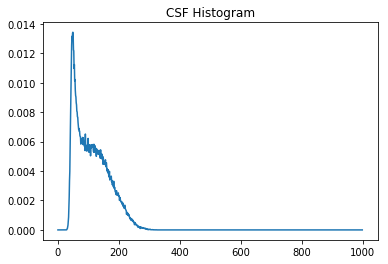

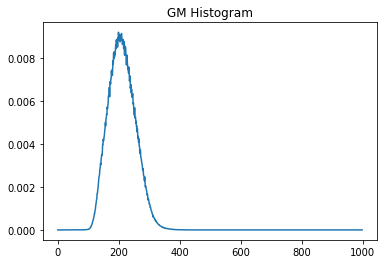

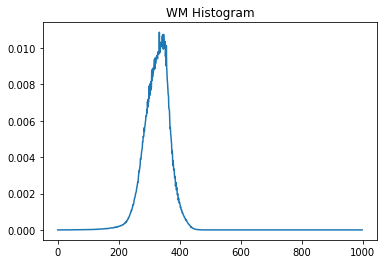

In [6]:
# plot histograms
plt.plot(bins, CSF_hist)
plt.title("CSF Histogram")
plt.show()

plt.plot(bins, GM_hist)
plt.title("GM Histogram")
plt.show()

plt.plot(bins, WM_hist)
plt.title("WM Histogram")
plt.show()

In [7]:
def get_hist_probs(img, hist):
    """Returns probability values for an image based on a given histogram.
    
    Parameters:
        img (np.ndarray): input image.
        hist (np.ndarray): histogram.
    
    Returns:
        out_prob (np.ndarray): propability image.
    """
    out_prob = np.zeros_like(img, dtype='float')
    # we assume that intensity values and indices of bins correspond
    for intens_val in np.nditer(np.nonzero(hist)):
        out_prob[img == intens_val] = hist[intens_val]
    
    return out_prob

## Combine Altlas and Histogram Information for Segmentation

In [8]:
onlydirs = [f for f in listdir(template_path) if isdir(join(template_path, f))]

all_dice = np.zeros((len(onlydirs),3))

for i, f in enumerate(onlydirs):
    test_data, _ = read_im(join(test_im_path,f+'.nii.gz'))
    test_data = normalize(test_data, max_intens)

    _, template_img = read_im(join(template_path,f,'result.1.nii'))
    GM_atlas, _ = read_im(join(atlas_path, f,'gm','result.nii.gz'))
    WM_atlas, _ = read_im(join(atlas_path, f,'wm','result.nii.gz'))
    CSF_atlas, _ = read_im(join(atlas_path, f,'csf','result.nii.gz'))

    # Incorporate historgram from above
    # compute probabilities based on intensity histograms
    GM_hist_prob = get_hist_probs(test_data, GM_hist)
    WM_hist_prob = get_hist_probs(test_data, WM_hist)
    CSF_hist_prob = get_hist_probs(test_data, CSF_hist)

    # combine those probabilities
    GM_atlas *= GM_hist_prob
    WM_atlas *= WM_hist_prob
    CSF_atlas *= CSF_hist_prob

    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
    WM = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))
    CSF = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
    seg_im = GM + WM + CSF
    segmented_img = nib.Nifti1Image(seg_im, template_img.affine, template_img.header)

    # Calculate DICE
    path_gt = join(gt_path,f+"_3C.nii.gz")
    _, groundtruth_img = read_im(path_gt)
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segmented_img, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    os.mkdir(new_dir)
    nib.save(segmented_img, join(new_dir,'atlas_hist_seg.nii.gz'))

print(all_dice)

[[0.92957539 0.74315853 0.87091927]
 [0.64713343 0.79719553 0.87965188]
 [0.7791162  0.74670768 0.84538043]
 [0.91418334 0.71954422 0.83575205]
 [0.87842365 0.67389358 0.79820432]
 [0.81203122 0.78234362 0.87376512]
 [0.85503523 0.76472271 0.87531826]
 [0.75197118 0.78258377 0.85764778]
 [0.66709503 0.76949915 0.85302563]
 [0.81606549 0.78506983 0.87952346]
 [0.69380168 0.76019248 0.86773718]
 [0.82328836 0.77562629 0.87389346]
 [0.89082114 0.72155107 0.8499561 ]
 [0.82920019 0.79833586 0.82958416]
 [0.83334351 0.69808035 0.81914145]
 [0.88235294 0.75186375 0.82697984]
 [0.81224617 0.72882252 0.8285719 ]
 [0.92240762 0.76717012 0.85046209]
 [0.76627469 0.77093132 0.8714622 ]
 [0.65461167 0.77575729 0.8809873 ]]


In [9]:
with open(out_dice_path, 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')